<a href="https://colab.research.google.com/github/dyna-bytes/PyTorchIntensive/blob/main/2_3_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'<<{_str}>>:')
        _str = ''
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}')

In [ ]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics torchviz

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.accelerators import accelerator
from torchmetrics import functional as FM
from torchinfo import summary

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.5]

torch.__version__,pl.__version__

('2.0.1+cu118', '2.0.3')

## Image Datasets

https://www.cs.toronto.edu/~kriz/cifar.html

In [ ]:
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10, CIFAR100
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
])

epochs=3
batch_size=1024

download_root = './MNIST'
train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
trainDataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valDataLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

download_root = './CIFAR10'
cifar10_train = CIFAR10(download_root, transform=mnist_transform, train=True, download=True)
cifar10_test = CIFAR10(download_root, transform=mnist_transform, train=True, download=True)
c10TrainDataLoader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
c10ValDataLoader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 87276456.95it/s]


Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24193268.19it/s]


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27382945.16it/s]


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4230630.42it/s]


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 170498071/170498071 [00:01<00:00, 92767622.64it/s] 


Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


In [ ]:
## target lable의 image 확인하기
def img_plot(data, lable, target):
    plt.figure(figsize=(12, 3))
    idx = 0
    data_ = data.permute(0, 2, 3, 1)
    for i in range(36):
        while lable[idx] != target :
            idx += 1
            if idx >=1024 : idx=0
        plt.subplot(3, 12, i+1)
        if data_.shape[-1] == 1:
            data_ = data_[..., 0]
        plt.imshow(data_[idx])
        plt.axis("off")
        idx += 1
    plt.show()

- 동일 class 이미지들의 다양성 확인하기

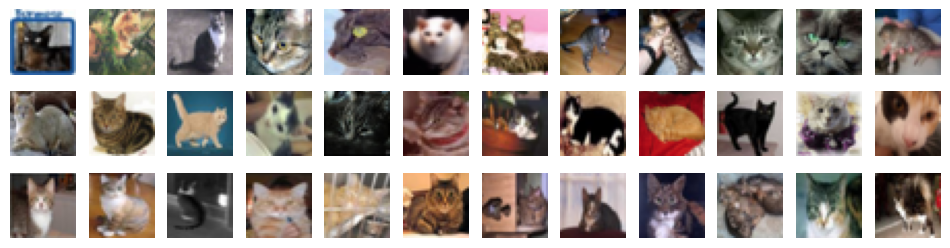

[] Shapetorch.Size([1024, 3, 32, 32]), <class 'torch.Tensor'>


In [ ]:
x_train, y_train = next(iter(c10TrainDataLoader))
img_plot(x_train, y_train, 3)
pst(x_train)

## Base Model : MNIST

In [ ]:
loss_function = nn.CrossEntropyLoss()
class Model(pl.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(num_parameters=256),
            nn.Dropout(0.2),
            nn.Linear(256, 10))

    def forward(self, x):
        x = self.layers(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = Model()
summary(model, input_size=(8, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Flatten: 2-1                      [8, 784]                  --
│    └─Linear: 2-2                       [8, 256]                  200,960
│    └─BatchNorm1d: 2-3                  [8, 256]                  512
│    └─PReLU: 2-4                        [8, 256]                  256
│    └─Dropout: 2-5                      [8, 256]                  --
│    └─Linear: 2-6                       [8, 10]                   2,570
Total params: 204,298
Trainable params: 204,298
Non-trainable params: 0
Total mult-adds (M): 1.63
Input size (MB): 0.03
Forward/backward pass size (MB): 0.05
Params size (MB): 0.82
Estimated Total Size (MB): 0.89

In [ ]:
%%time
model = Model()

name = 'base'
logger = pl.loggers.CSVLogger("logs", name=name)
trainer = pl.Trainer(max_epochs=15, logger=logger, accelerator='auto',)#overfit_batches=0.3)
trainer.fit(model, trainDataLoader, valDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 204 K 
--------------------------------------
204 K     Trainable params
0         Non-trainable params
204 K     Total params
0.817     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


CPU times: user 2min 21s, sys: 524 ms, total: 2min 22s
Wall time: 2min 28s


Wall time: 2min 28s

In [ ]:
v_num = logger.version
history = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv')
df = history.groupby('epoch').mean().drop('step', axis=1)

MaxAcc:[ 0.979200005531311 ]


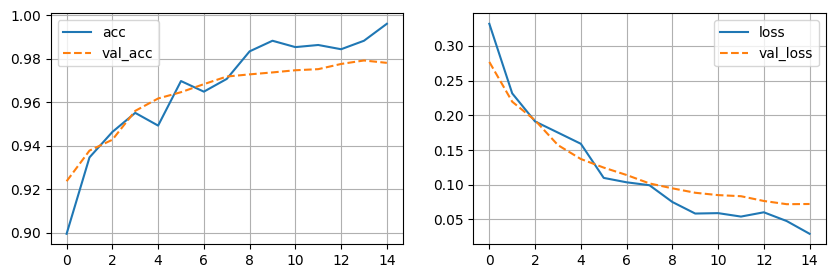

In [ ]:
import matplotlib.pylab as plt
print('MaxAcc:[',df['val_acc'].max(),']')
fig = plt.figure(figsize = (10, 3.))
plt.subplot(121)
plt.plot(df['acc'], linestyle='-', label="acc")
plt.plot(df['val_acc'], linestyle='--', label="val_acc")
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(df['loss'], linestyle='-', label="loss")
plt.plot(df['val_loss'], linestyle='--', label="val_loss")

plt.legend()
plt.grid()
plt.show()

## 실습 : CIFAR-10

실습
Sample code에서 시작하여 모델을 개선하세요
최종모델 code와 학습과정을 제출하세요.

**Step 1** :
input dataset 을 CIFAR-10 으로 바꾸고
기본 모델과, BatchNormalization Layer를 추가한
모델의 성능변화를 확인 하세요.
Input data의 shape에 주의
**Step 2** :
모델 개선 : Layer추가 및 기타 개선
Dropout등 도 추가, val_acc가 최고인 모델을 만들어 보세요.
성능개선에 영향를 주는 요인 파악
Epoch = 15, batch_size = 1024 유지
**Step 3** :
목표 : val_acc 50%이상
Epoch = 15, batch_size = 1024 유지


In [ ]:
### input dataset을 CIFA-10으로 바꿔봅니다.

In [ ]:
# 데이터 준비
x_train, y_train = next(iter(c10TrainDataLoader))
x_test, y_test = next(iter(c10ValDataLoader))
pst(x_train)

[] Shapetorch.Size([1024, 3, 32, 32]), <class 'torch.Tensor'>


In [ ]:
p(y_train)

<<>>:
Shape:torch.Size([1024])
Type: <class 'torch.Tensor'>
Values: tensor([7, 8, 3,  ..., 2, 9, 3])


실습 코드와 결과를 아래에 저장 하세요.

### 실습 실험 1

In [ ]:
loss_function = nn.CrossEntropyLoss()
class Model(pl.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*32*32, 128),
            nn.BatchNorm1d(128),
            nn.PReLU(),

            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.PReLU(),

            nn.Dropout(0.2),
            nn.Linear(128, 10))

    def forward(self, x):
        out = self.layers(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = Model()
summary(model, input_size=(8, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Flatten: 2-1                      [8, 3072]                 --
│    └─Linear: 2-2                       [8, 128]                  393,344
│    └─BatchNorm1d: 2-3                  [8, 128]                  256
│    └─PReLU: 2-4                        [8, 128]                  1
│    └─Linear: 2-5                       [8, 128]                  16,512
│    └─BatchNorm1d: 2-6                  [8, 128]                  256
│    └─PReLU: 2-7                        [8, 128]                  1
│    └─Dropout: 2-8                      [8, 128]                  --
│    └─Linear: 2-9                       [8, 10]                   1,290
Total params: 411,660
Trainable params: 411,660
Non-trainable params: 0
Total mult-adds (M): 3.29
Input size (MB): 0.10
Forward/backward pass s

In [ ]:
%%time
model = Model()

name = 'base'
logger = pl.loggers.CSVLogger("logs", name=name)
trainer = pl.Trainer(max_epochs=15, logger=logger, accelerator='auto',)#overfit_batches=0.3)
trainer.fit(model, c10TrainDataLoader, c10ValDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 411 K 
--------------------------------------
411 K     Trainable params
0         Non-trainable params
411 K     Total params
1.647     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (49) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


CPU times: user 4min 44s, sys: 1.05 s, total: 4min 45s
Wall time: 4min 46s


Wall time: 2min 28s

In [ ]:
v_num = logger.version
history = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv')
df = history.groupby('epoch').mean().drop('step', axis=1)

MaxAcc:[ 0.5679399967193604 ]


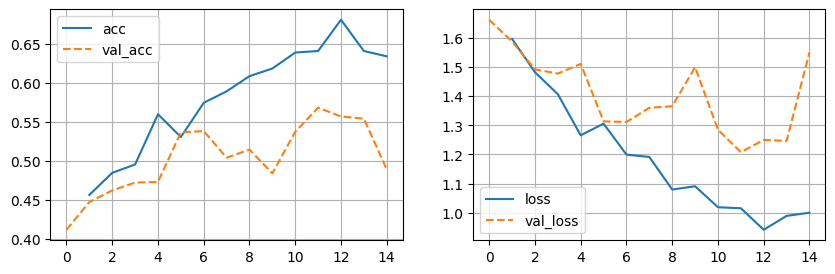

In [ ]:
import matplotlib.pylab as plt
print('MaxAcc:[',df['val_acc'].max(),']')
fig = plt.figure(figsize = (10, 3.))
plt.subplot(121)
plt.plot(df['acc'], linestyle='-', label="acc")
plt.plot(df['val_acc'], linestyle='--', label="val_acc")
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(df['loss'], linestyle='-', label="loss")
plt.plot(df['val_loss'], linestyle='--', label="val_loss")

plt.legend()
plt.grid()
plt.show()

Wall time: 2min 28s

### 실습 실험 2

In [ ]:
loss_function = nn.CrossEntropyLoss()
class Model(pl.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(num_parameters=256),
            nn.Dropout(0.2),
            nn.Linear(256, 10))
    def forward(self, x):
        out = self.layers(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = Model()
summary(model, input_size=(8, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Flatten: 2-1                      [8, 3072]                 --
│    └─Linear: 2-2                       [8, 256]                  786,688
│    └─BatchNorm1d: 2-3                  [8, 256]                  512
│    └─PReLU: 2-4                        [8, 256]                  256
│    └─Dropout: 2-5                      [8, 256]                  --
│    └─Linear: 2-6                       [8, 10]                   2,570
Total params: 790,026
Trainable params: 790,026
Non-trainable params: 0
Total mult-adds (M): 6.32
Input size (MB): 0.10
Forward/backward pass size (MB): 0.05
Params size (MB): 3.16
Estimated Total Size (MB): 3.31

In [ ]:
%%time
model = Model()

name = 'Model1'
logger = pl.loggers.CSVLogger("logs", name=name)
trainer = pl.Trainer(max_epochs=15, logger=logger, accelerator='auto')
trainer.fit(model, c10TrainDataLoader, c10ValDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 790 K 
--------------------------------------
790 K     Trainable params
0         Non-trainable params
790 K     Total params
3.160     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (49) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


CPU times: user 4min 45s, sys: 1.21 s, total: 4min 46s
Wall time: 4min 47s


Wall time: 4min 33s

In [ ]:
v_num = logger.version
history = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv')
df = history.groupby('epoch').mean().drop('step', axis=1)

MaxAcc:[ 0.5457000136375427 ]


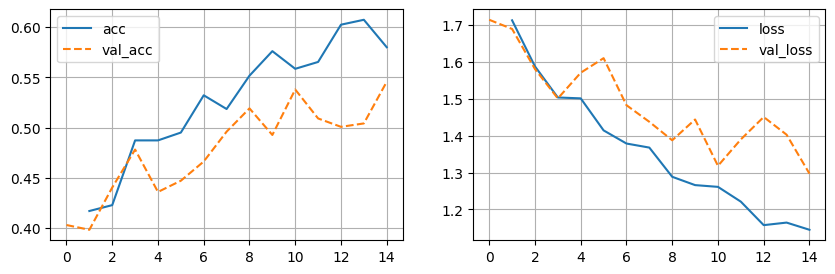

In [ ]:
print('MaxAcc:[',df['val_acc'].max(),']')

fig = plt.figure(figsize = (10, 3.))
plt.subplot(121)
plt.plot(df['acc'], linestyle='-', label="acc")
plt.plot(df['val_acc'], linestyle='--', label="val_acc")
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(df['loss'], linestyle='-', label="loss")
plt.plot(df['val_loss'], linestyle='--', label="val_loss")

plt.legend()
plt.grid()
plt.show()

### 실습 실험 3

In [ ]:
loss_function = nn.CrossEntropyLoss()
class Model(pl.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*32*32, 128),
            nn.BatchNorm1d(128),
            nn.PReLU(),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.PReLU(),

            nn.Dropout(0.2),
            nn.Linear(64, 10))

    def forward(self, x):
        out = self.layers(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = Model()
summary(model, input_size=(8, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Flatten: 2-1                      [8, 3072]                 --
│    └─Linear: 2-2                       [8, 128]                  393,344
│    └─BatchNorm1d: 2-3                  [8, 128]                  256
│    └─PReLU: 2-4                        [8, 128]                  1
│    └─Linear: 2-5                       [8, 64]                   8,256
│    └─BatchNorm1d: 2-6                  [8, 64]                   128
│    └─PReLU: 2-7                        [8, 64]                   1
│    └─Dropout: 2-8                      [8, 64]                   --
│    └─Linear: 2-9                       [8, 10]                   650
Total params: 402,636
Trainable params: 402,636
Non-trainable params: 0
Total mult-adds (M): 3.22
Input size (MB): 0.10
Forward/backward pass size

In [ ]:
%%time
model = Model()

name = 'base'
logger = pl.loggers.CSVLogger("logs", name=name)
trainer = pl.Trainer(max_epochs=15, logger=logger, accelerator='auto',)#overfit_batches=0.3)
trainer.fit(model, c10TrainDataLoader, c10ValDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 402 K 
--------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.611     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (49) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


CPU times: user 4min 54s, sys: 1.24 s, total: 4min 56s
Wall time: 5min 11s


Wall time: 2min 28s

In [ ]:
v_num = logger.version
history = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv')
df = history.groupby('epoch').mean().drop('step', axis=1)

MaxAcc:[ 0.5587599873542786 ]


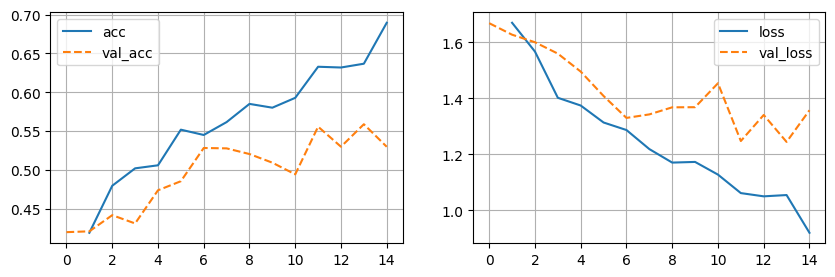

In [ ]:
import matplotlib.pylab as plt
print('MaxAcc:[',df['val_acc'].max(),']')
fig = plt.figure(figsize = (10, 3.))
plt.subplot(121)
plt.plot(df['acc'], linestyle='-', label="acc")
plt.plot(df['val_acc'], linestyle='--', label="val_acc")
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(df['loss'], linestyle='-', label="loss")
plt.plot(df['val_loss'], linestyle='--', label="val_loss")

plt.legend()
plt.grid()
plt.show()

Wall time: 2min 28s

## 실습결과 예시

## 결과 : Step 1, 2

In [ ]:
loss_function = nn.CrossEntropyLoss()
class Model(pl.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*32*32, 128), ##
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 10))

    def forward(self, x):
        out = self.layers(x)
        return out

model = Model()
summary(model, input_size=(8, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Flatten: 2-1                      [8, 3072]                 --
│    └─Linear: 2-2                       [8, 128]                  393,344
│    └─BatchNorm1d: 2-3                  [8, 128]                  256
│    └─ReLU: 2-4                         [8, 128]                  --
│    └─Dropout: 2-5                      [8, 128]                  --
│    └─Linear: 2-6                       [8, 10]                   1,290
Total params: 394,890
Trainable params: 394,890
Non-trainable params: 0
Total mult-adds (M): 3.16
Input size (MB): 0.10
Forward/backward pass size (MB): 0.02
Params size (MB): 1.58
Estimated Total Size (MB): 1.69

## 결과 : Step 3

In [ ]:
loss_function = nn.CrossEntropyLoss()
class Model(pl.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 10),
            nn.BatchNorm1d(10))

    def forward(self, x):
        out = self.layers(x)
        return out

model = Model()
summary(model, input_size=(8, 3, 32, 32))

In [ ]:
loss_function = nn.CrossEntropyLoss()
class Model(pl.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(num_parameters=256),
            nn.Dropout(0.2),
            nn.Linear(256, 10))
    def forward(self, x):
        out = self.layers(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = Model()
summary(model, input_size=(8, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Flatten: 2-1                      [8, 3072]                 --
│    └─Linear: 2-2                       [8, 256]                  786,688
│    └─BatchNorm1d: 2-3                  [8, 256]                  512
│    └─PReLU: 2-4                        [8, 256]                  256
│    └─Dropout: 2-5                      [8, 256]                  --
│    └─Linear: 2-6                       [8, 10]                   2,570
Total params: 790,026
Trainable params: 790,026
Non-trainable params: 0
Total mult-adds (M): 6.32
Input size (MB): 0.10
Forward/backward pass size (MB): 0.05
Params size (MB): 3.16
Estimated Total Size (MB): 3.31

In [ ]:
%%time
model = Model()

name = 'Model1'
logger = pl.loggers.CSVLogger("logs", name=name)
trainer = pl.Trainer(max_epochs=15, logger=logger, accelerator='auto')
trainer.fit(model, c10TrainDataLoader, c10ValDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 790 K 
--------------------------------------
790 K     Trainable params
0         Non-trainable params
790 K     Total params
3.160     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (49) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


CPU times: user 4min 19s, sys: 1 s, total: 4min 20s
Wall time: 4min 33s


Wall time: 4min 33s

In [ ]:
v_num = logger.version
history = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv')
df = history.groupby('epoch').mean().drop('step', axis=1)

In [ ]:
print('MaxAcc:[',df['val_acc'].max(),']')

fig = plt.figure(figsize = (10, 3.))
plt.subplot(121)
plt.plot(df['acc'], linestyle='-', label="acc")
plt.plot(df['val_acc'], linestyle='--', label="val_acc")
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(df['loss'], linestyle='-', label="loss")
plt.plot(df['val_loss'], linestyle='--', label="val_loss")

plt.legend()
plt.grid()
plt.show()

MaxAcc:[ 0.5547199845314026 ]
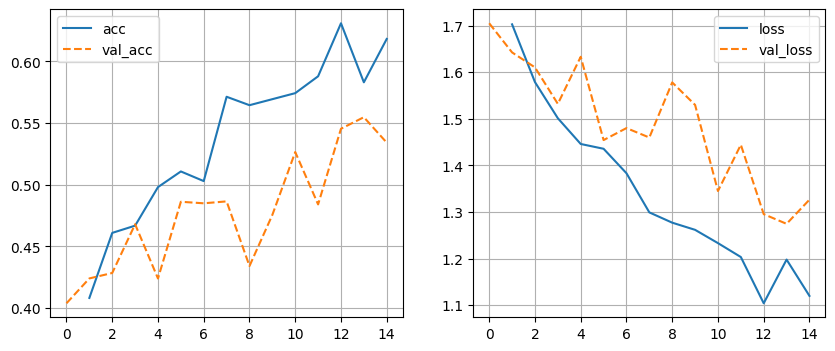